## Evaluation of LLM Performance for Causality Classification

### API call, model list, imports

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import requests
import json
from google.colab import userdata
import re

OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')

from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=OPENROUTER_API_KEY,
)

model_list = ['openai/gpt-4o-mini',
              'anthropic/claude-3.7-sonnet',
              'google/gemini-2.5-flash-preview',
              'deepseek/deepseek-chat-v3-0324',
              'meta-llama/llama-3.3-70b-instruct',
              'mistralai/mistral-nemo',
              'qwen/qwen3-235b-a22b',
              'amazon/nova-lite-v1',
              'cohere/command-r-08-2024']

### Defined functions (prompt, model run, evaluation functions)

In [ ]:
### Prompting functions

def prompt_zeroshot(sentence):
    return (f"""You are an expert in identifying causal links. Perform classification for an input sentence according to the following categories:\n\n
    - **Strong Causation**: A sentence that explains a cause-effect relation, possibly detailing multiple steps in the causal process.\n
    - **Contrastive**: A sentence that explains a relation between multiple multiple pairs of variables, with each pair in opposition to another.\n
    - **Weak Causation**: A sentence that explains relationships between variables with indirect causality, emphasising the role of features or conscious behaviors.\n
    - **No Explanation**: A sentence that does not provide an explanation.\n\n
    Your response must ONLY be the name of the category the sentence belongs to. No other text or explanation.\n\n
    **Input Sentence**: {sentence}\n
    **Output**:""")

def prompt_fewshot(sentence):
    return (f"""You are an expert in identifying causal links. Perform classification for an input sentence according to the following categories:\n\n
    - **Strong Causation**: A sentence that explains a cause-effect relation, possibly detailing multiple steps in the causal process.\n
    - **Contrastive**: A sentence that explains a relation between multiple multiple pairs of variables, with each pair in opposition to another.\n
    - **Weak Causation**: A sentence that explains relationships between variables with indirect causality, emphasising the role of features or conscious behaviors.\n
    - **No Explanation**: A sentence that does not provide an explanation.\n\n
    These are examples of classified sentences:\n\n
    **Input Sentence**:When two tectonic plates collide or move toward each other, immense pressure builds up as the plates push against one another, resulting in the folding, faulting, and uplifting of the Earth's crust and forming mountain ranges over millions of years.\n
    **Output:**Strong Causation\n
    **Input Sentence**: In mutualistic relationships, both species benefit from the interaction, like bees pollinating flowers, while in coevolution, species evolve in response to each other, such as the adaptation of predator and prey to one another’s strategies.\n
    **Output**: Contrastive\n
    **Input Sentence**: Cross-sectional studies are chosen for their speed, low cost, ability to analyze a large population at once, efficiency in identifying health trends, and ease of interpretation.\n
    **Output**:Weak Causation\n
    **Input Sentence**: One is a genius, the other's insane, it's the two cartoon mice.\n
    **Output**:No Explanation.\n\n
    Your response must ONLY be the name of the category the sentence belongs to. No other text or explanation.\n\n
    **Input Sentence**: {sentence}\n
    **Output**:""")

def prompt_chainofthought(sentence):
    return (f"""You are an expert in identifying causal links. Perform classification for an input sentence according to the following categories:\n\n
    - **Strong Causation**: A sentence that explains a cause-effect relation, possibly detailing multiple steps in the causal process.\n
    - **Contrastive**: A sentence that explains a relation between multiple multiple pairs of variables, with each pair in opposition to another.\n
    - **Weak Causation**: A sentence that explains relationships between variables with indirect causality, emphasising the role of features or conscious behaviors.\n
    - **No Explanation**: A sentence that does not provide an explanation.\n\n
    These are examples of classified sentences:\n\n
    **Input Sentence**:When two tectonic plates collide or move toward each other, immense pressure builds up as the plates push against one another, resulting in the folding, faulting, and uplifting of the Earth's crust and forming mountain ranges over millions of years.\n
    **Output:**The sentence explains a cause-effect relation between tectonic plates colliding and the folding of the Earth's crust. The folding of the Earth's crust is related to the mountains rising. The category is: Strong Causation\n
    **Input Sentence**: In mutualistic relationships, both species benefit from the interaction, like bees pollinating flowers, while in coevolution, species evolve in response to each other, such as the adaptation of predator and prey to one another’s strategies.\n
    **Output**: The sentence explains how mutualistic relationships work with an example, and then explains coevolution, which is a different situation, to make a comparison. The category is: Contrastive\n
    **Input Sentence**: Cross-sectional studies are chosen for their speed, low cost, ability to analyze a large population at once, efficiency in identifying health trends, and ease of interpretation.\n
    **Output**: The sentence identifies multiple reason for choosing cross-sectional studies. Since the studies are chosen, the sentence expresses conscious behavior. The category is: Weak Causation\n
    **Input Sentence**: One is a genius, the other's insane, it's the two cartoon mice.\n
    **Output**: The sentence has no causal explanations, no contrast between different examples and does not present evolutionary features or behavior patterns. The category is: No Explanation.\n\n
    **Input Sentence**: {sentence}\n
    **Output**:""")

### Model running function for selected list of LLMs

def multiLLM_run(list_of_models, list_of_sentences, prompt_type):
  for mod in list_of_models:
    selected_model = mod
    file_out = selected_model.split("/")[1]+".txt"
    out_list = list()
    for sentence in list_of_sentences:
      completion = client.chat.completions.create(
        model=selected_model,
        temperature=0,
        max_tokens=256,
        response_format={"type": "text"},
        messages=[
          {
            "role": "user",
            "content": prompt_type(sentence)
          }
        ]
      )
      out_list.append(completion.choices[0].message.content)
    with open(file_out, "w") as out:
      out.write("\n".join(out_list))

### Evaluation functions for zero-few shot and cleaned chain-of-thought

def x_shot_eval(shot_number, model_list, truth_list):
  for mod in model_list:
    modname = shot_number+'shot-'+mod.split("/")[1]+'.txt'
    modpred = list()
    with open(modname, 'r') as outp:
      for line in outp:
        c3 = ''.join( c for c in line if  c not in '*"[1]' )
        klist = list(k for k in mod_valkeys.keys() if k in c3.strip())
        modpred.append(mod_valkeys[klist[0]])
    if len(modpred) < len(truth_list):
      modpred.extend([3] * (len(truth_list) - len(modpred)))
    evals_dic[modname.strip('.txt')] = modpred
    print(modname, "///", f1_score(truth_list, modpred, average='micro'))

def cot_eval(model_list, truth_list):
  for mod in model_list:
    modname = 'cleancot-'+mod.split("/")[1]+'.txt'
    modpred = list()
    with open(modname, 'r') as outp:
      for line in outp:
        modpred.append(mod_valkeys[line.strip()])
    if len(modpred) < len(truth_list):
      modpred.extend([3] * (len(truth_list) - len(modpred)))
    evals_dic[modname.strip('.txt')] = modpred
    print(modname, "///", f1_score(truth_list, modpred, average='micro'))

### Dataset processing (sentence list for prompting, list of ground truth labels)

In [ ]:
### Open the SciExpl tsv file to process the dataset

sents = []

with open("scientific_explanation_dataset.tsv", "r") as sciexpl:
  for line in sciexpl:
    sent = line.split("\t")[0]
    sents.append(sent.strip('" '))
del sents[0]

### Key dictionary to convert into numerical label for later automated scoring

valkeys = {'Strong Cause':0,
           'Weak Cause':1,
           'Multi-path / Contrastive':2,
           'No Explanation':3}
ground_truth = []

with open("scientific_explanation_dataset.tsv", "r") as sciexpl:
  for line in sciexpl:
    sent = line.split("\t")[2]
    if sent.strip() != 'Second Categorization':
      ground_truth.append(valkeys[sent.strip()])

evals_dic = dict()

mod_valkeys = {'Strong Causation':0,
               'Strong':0,
               'Strong C':0,
               'Strong Caus':0,
               'Weak Causation':1,
               'Contrastive':2,
               'Contr':2,
               'No Explanation':3,
               '':3,
               '[1]':3}

### Running the LLMs

In [ ]:
multiLLM_run(model_list, sents, prompt_chainofthought)

### Evaluation and plotting of matrices

In [ ]:
x_shot_eval('zero',model_list,ground_truth)

zeroshot-gpt-4o-mini.txt /// 0.5955882352941176
zeroshot-claude-3.7-sonnet.txt /// 0.6875
zeroshot-gemini-2.5-flash-preview.txt /// 0.6544117647058824
zeroshot-deepseek-chat-v3-0324.txt /// 0.5882352941176471
zeroshot-llama-3.3-70b-instruct.txt /// 0.6360294117647058
zeroshot-mistral-nemo.txt /// 0.5514705882352942
zeroshot-qwen3-235b-a22b.txt /// 0.36764705882352944
zeroshot-nova-lite-v1.txt /// 0.6139705882352942
zeroshot-command-r-08-2024.txt /// 0.5036764705882353


In [ ]:
x_shot_eval('few',model_list,ground_truth)

fewshot-gpt-4o-mini.txt /// 0.6764705882352942
fewshot-claude-3.7-sonnet.txt /// 0.8419117647058824
fewshot-gemini-2.5-flash-preview.txt /// 0.8272058823529411
fewshot-deepseek-chat-v3-0324.txt /// 0.6838235294117647
fewshot-llama-3.3-70b-instruct.txt /// 0.7242647058823529
fewshot-mistral-nemo.txt /// 0.7352941176470589
fewshot-qwen3-235b-a22b.txt /// 0.33088235294117646
fewshot-nova-lite-v1.txt /// 0.6507352941176471
fewshot-command-r-08-2024.txt /// 0.6544117647058824


In [ ]:
cot_eval(model_list, ground_truth)

cleancot-gpt-4o-mini.txt /// 0.7205882352941176
cleancot-claude-3.7-sonnet.txt /// 0.8161764705882353
cleancot-gemini-2.5-flash-preview.txt /// 0.8455882352941176
cleancot-deepseek-chat-v3-0324.txt /// 0.7095588235294118
cleancot-llama-3.3-70b-instruct.txt /// 0.7463235294117647
cleancot-mistral-nemo.txt /// 0.35294117647058826
cleancot-qwen3-235b-a22b.txt /// 0.06985294117647059
cleancot-nova-lite-v1.txt /// 0.7132352941176471
cleancot-command-r-08-2024.txt /// 0.6580882352941176


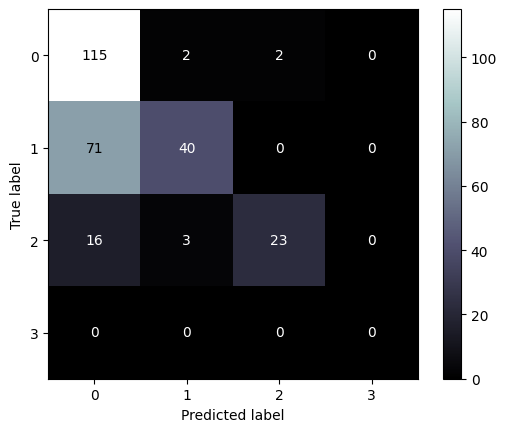

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictions = evals_dic['zeroshot-gemini-2.5-flash-preview']
cm = confusion_matrix(ground_truth, predictions, labels=[0,1,2,3],)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3])
disp.plot(cmap='bone')
plt.show()